In [1]:
# !pip install eli5 lime scikeras streamlit imblearn
import joblib

In [2]:
import numpy as np
import pandas as pd

from eli5.permutation_importance import get_score_importances

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline 

from ipywidgets import widgets
from ipywidgets import interactive

from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from lime.lime_tabular import LimeTabularExplainer

from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from scikeras.wrappers import KerasClassifier

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# https://docs.google.com/spreadsheets/d/1CLAAgePXKkayY_KTCFjK4w5_qbi2FUhM/edit?usp=sharing&ouid=108171422150379399380&rtpof=true&sd=true
# !gdown --id "1CLAAgePXKkayY_KTCFjK4w5_qbi2FUhM"

In [4]:
df_long_demog = pd.read_excel("OASIS_2/oasis_longitudinal_demographics.xlsx", engine='openpyxl')

In [5]:
df_long_demog.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678.290000,0.736336,1.045710
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1737.620000,0.713402,1.010000
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1697.911134,0.701236,1.033623


In [6]:
df_long_demog.isna().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [7]:
df_long_demog.isna().sum()/len(df_long_demog)

Subject ID    0.000000
MRI ID        0.000000
Group         0.000000
Visit         0.000000
MR Delay      0.000000
M/F           0.000000
Hand          0.000000
Age           0.000000
EDUC          0.000000
SES           0.050938
MMSE          0.005362
CDR           0.000000
eTIV          0.000000
nWBV          0.000000
ASF           0.000000
dtype: float64

In [8]:
# df_long_demog['M/F'].value_counts()

None of the features on first pass examination have >5.1% missing values. We've still got to exmaine the object-type and numeric features to check for abnormal/irregular/extreme-value entries.

In [9]:
df_long_demog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    float64
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(6), int64(4), object(5)
memory usage: 43.8+ KB


Since the column `SES` has missing values, let's have a deeper look at it.

In [10]:
df_long_demog['SES'].unique()

array([ 2., nan,  3.,  4.,  1.,  5.])

Seems like the column has a float encoding but all possible values this data takes is that of whole numbers.

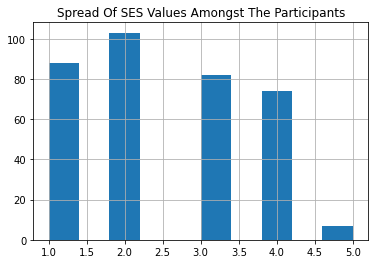

In [11]:
plt.title('Spread Of SES Values Amongst The Participants')
df_long_demog['SES'].hist();

Info about the MMSE:


1. How is the MMSE scored?
- The maximum score for the MMSE is 30. A score of 25 or higher is classed as normal. If the score is below 24, the result is usually considered to be abnormal, indicating possible cognitive impairment.

2. What are the limitations of the MMSE?
- There are limitations to the MMSE which means that your doctor or healthcare professional will take care when interpreting the results.

- A high MMSE score does not necessarily mean that you don’t have cognitive impairment. Similarly, a low score does not necessarily mean that you have dementia. Sometimes, certain physical disabilities, language, speech, education level or cultural differences can affect the score.

- For example, a highly educated person with dementia might still score highly, especially early in their disease.

- Your doctor will take this into account when interpreting the results and they will advise if they think you should have further tests or assessments. An MMSE is just one part of a diagnosis of cognitive impairment or dementia.

###In isolation, it will not diagnose you with any disease, such as dementia

source: https://www.healthdirect.gov.au/mini-mental-state-examination-mmse

In [12]:
sorted(df_long_demog['MMSE'].unique()), df_long_demog['MMSE'].nunique()

([4.0,
  7.0,
  15.0,
  16.0,
  17.0,
  18.0,
  19.0,
  20.0,
  21.0,
  22.0,
  23.0,
  24.0,
  25.0,
  26.0,
  27.0,
  28.0,
  29.0,
  30.0,
  nan],
 18)

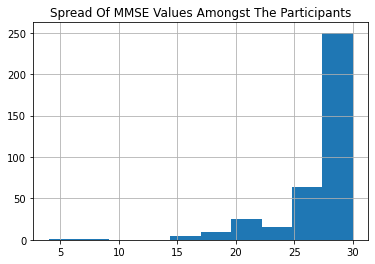

In [13]:
plt.title('Spread Of MMSE Values Amongst The Participants')
df_long_demog['MMSE'].hist();


From 4-15 there seem to be holes in data. That prompts us to a question, do low values indicate a high degree of severity? or is there an enviromental bias that makes these ranges to have missing values? or is it random?

In [14]:
df_long_demog.groupby("Group")['MMSE'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
Converted,37.0,28.675676,1.564432,24.0,28.0,29.0,30.0,30.0
Demented,144.0,24.513889,4.497064,4.0,22.0,26.0,28.0,30.0
Nondemented,190.0,29.226316,0.882722,26.0,29.0,29.0,30.0,30.0


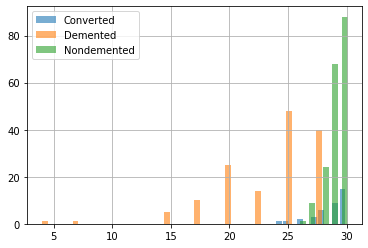

In [15]:
df_long_demog.groupby("Group")['MMSE'].hist(alpha=0.6, legend=True, width=0.5);

The charts correspond to our initial expectation of what the feature values imply.

In [16]:
df_long_demog.groupby("Group")['SES'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
Converted,37.0,1.729730,0.961730,1.0,1.0,1.0,2.0,4.0
Demented,127.0,2.771654,1.196483,1.0,2.0,3.0,4.0,5.0
Nondemented,190.0,2.394737,1.047534,1.0,2.0,2.0,3.0,5.0


the reason we look for similarities across groups is to get an idea on whether `SES` is provides a "all else equal" state.

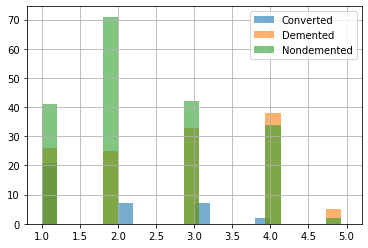

In [17]:
df_long_demog.groupby("Group")['SES'].hist(alpha=0.6, bins=15, legend=True, width=0.2);

Let's declutter the overlap

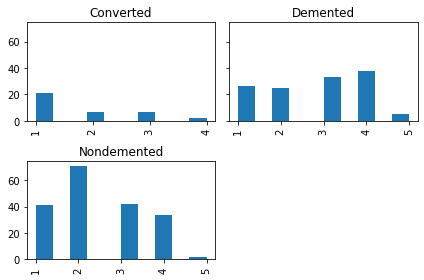

In [18]:
df_long_demog.hist('SES',by='Group', sharey=True)
plt.tight_layout()

In [19]:
df_long_demog[df_long_demog.SES.isna()].describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,19.000000,19.000000,19.000000,19.000000,0.0,17.000000,19.000000,19.000000,19.000000,19.000000
mean,1.842105,478.684211,76.631579,12.631579,NaN,25.941176,0.657895,1453.362766,0.723821,1.226740
std,0.898342,532.258088,3.112886,1.498537,NaN,2.726504,0.238783,184.346122,0.019520,0.160954
min,1.000000,0.000000,71.000000,12.000000,NaN,20.000000,0.500000,1158.567258,0.696097,1.010000
25%,1.000000,0.000000,75.000000,12.000000,NaN,23.000000,0.500000,1336.850000,0.706862,1.089894
50%,2.000000,518.000000,76.000000,12.000000,NaN,27.000000,0.500000,1453.050000,0.726850,1.207810
75%,2.000000,673.000000,79.000000,12.000000,NaN,27.000000,1.000000,1611.364473,0.736662,1.313095
max,4.000000,1895.000000,83.000000,16.000000,NaN,30.000000,1.000000,1737.620000,0.762489,1.514802


quick note: the 2 missing `MMSE` values occur only when the `SES` value is missing too.

In [20]:
df_long_demog[df_long_demog.SES.notna()].describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,1.884181,601.353107,77.033898,14.703390,2.460452,27.409605,0.271186,1489.987170,0.729863,1.193782
std,0.925330,640.596081,7.811808,2.895662,1.134005,3.712626,0.370537,175.762130,0.037847,0.136833
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1105.652499,0.644399,0.875539
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1358.047821,0.698730,1.100214
50%,2.000000,559.500000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.457128,0.729113,1.193506
75%,2.000000,882.500000,82.000000,16.750000,3.000000,30.000000,0.500000,1595.150095,0.756883,1.292297
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.479526,0.836842,1.587298


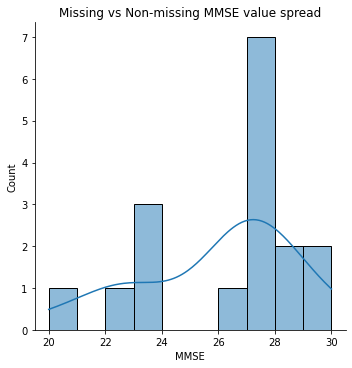

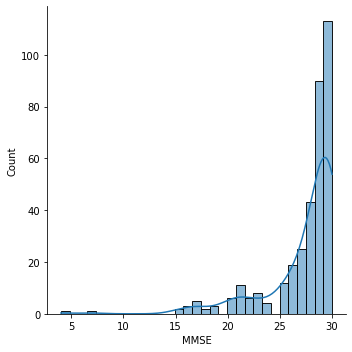

In [21]:

sns.displot(df_long_demog[df_long_demog.SES.isna()].MMSE, kde=True, bins=10);
plt.title("Missing vs Non-missing MMSE value spread")
sns.displot(df_long_demog[df_long_demog.SES.notna()].MMSE, kde=True);


The above kde-plots are just to show how densities can be misleading at times when there are holes in the data.

Post our quick analysis on variables with missing values and what the possible reasons could be, we can now move ahead with this understanding to the exploratory analysis of the other varaibles and how they interact with eachother in general.

We could in a general case discard missing data given that it falls below the arbitrary 5% threshold but since medical data is precious, it's worth a try to see if there is any reason for it to happen given that we had no control over the data collection process.

In [22]:
df_long_demog.columns


Index(['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand',
       'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')

In [24]:
df_not_na = df_long_demog.dropna()
df_not_na.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215.330000,0.709512,1.444060
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200.100000,0.718214,1.462380
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1688.580000,0.711502,1.039330


Quick look into the distributions to see if all is normal

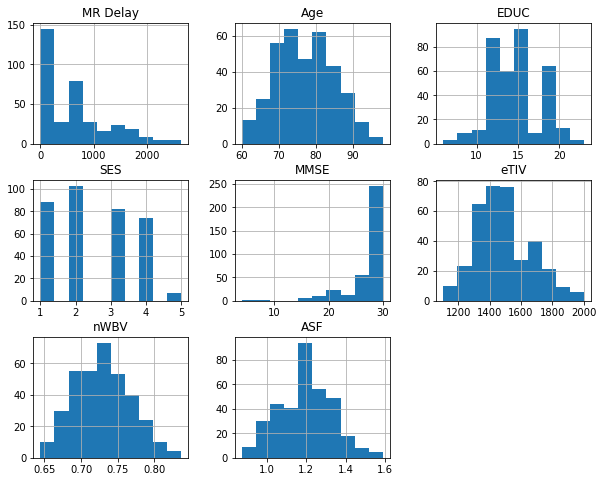

In [26]:
df_not_na[['MR Delay','Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']].hist(figsize=(10,8));

In [ ]:
all_feat = ['MR Delay', 'M/F','Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF', 'CDR']

#### Let's get a pairplot to see how the variables interact with each other.

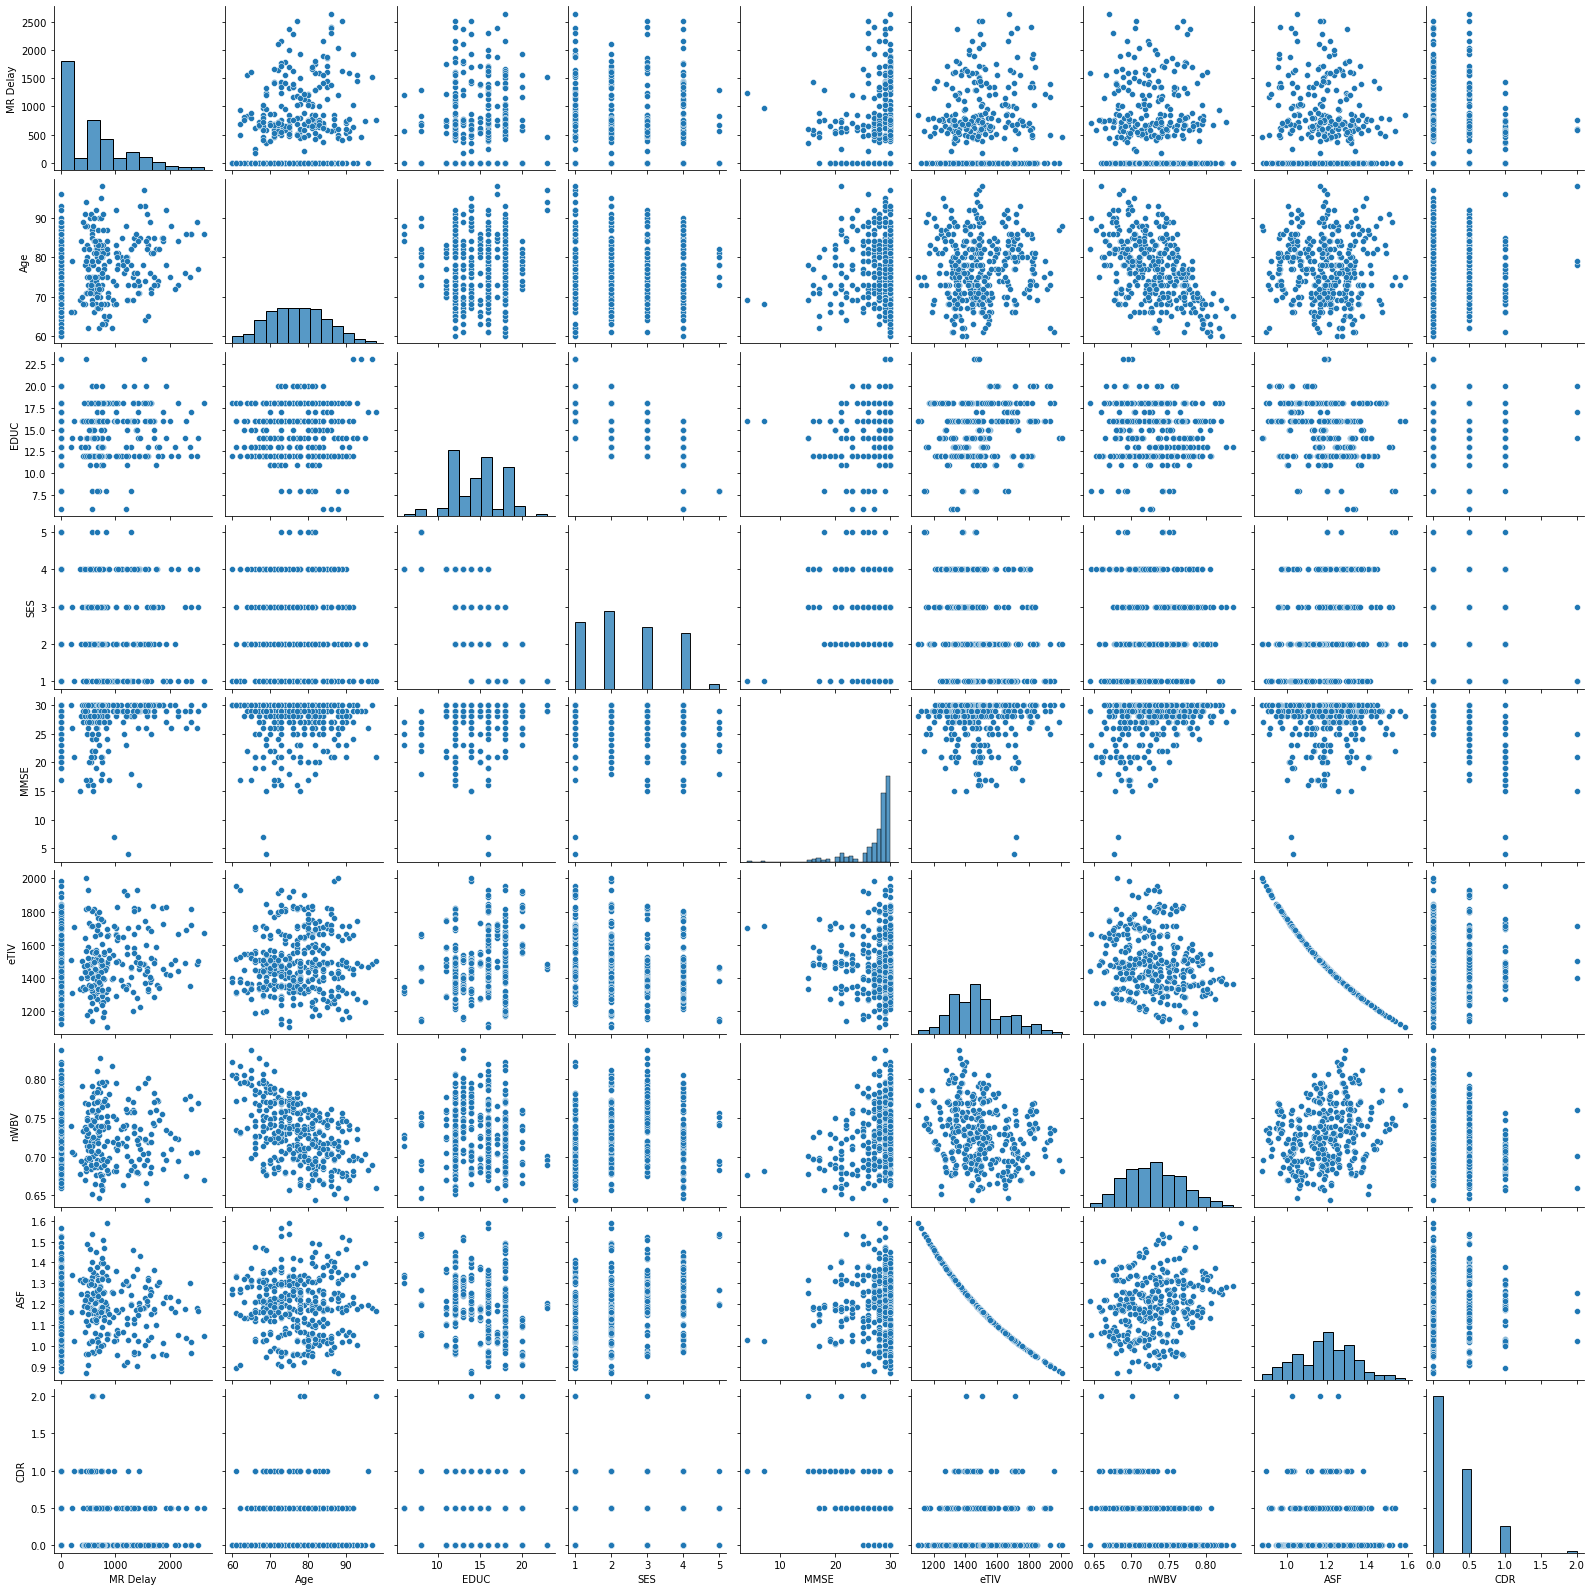

In [224]:
sns.pairplot(df_not_na[all_feat]);

In [229]:
temp_df = df_not_na[all_feat].copy()
temp_df

,MR Delay,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,CDR
0,0,M,87,14,2.0,27.0,1986.550000,0.696106,0.883440,0.0
1,457,M,88,14,2.0,30.0,2004.479526,0.681062,0.875539,0.0
5,0,F,88,18,3.0,28.0,1215.330000,0.709512,1.444060,0.0
6,538,F,90,18,3.0,27.0,1200.100000,0.718214,1.462380,0.0
7,0,M,80,12,4.0,28.0,1688.580000,0.711502,1.039330,0.0
...,...,...,...,...,...,...,...,...,...,...
368,842,M,82,16,1.0,28.0,1692.880000,0.693926,1.036690,0.5
369,2297,M,86,16,1.0,26.0,1688.009649,0.675457,1.039686,0.5
370,0,F,61,13,2.0,30.0,1319.020000,0.801006,1.330540,0.0
371,763,F,63,13,2.0,30.0,1326.650000,0.795981,1.322890,0.0


- H0: Both Males and Females don't have differing average CDR's
- H1: There is a significant difference

In [235]:
from scipy import stats
rvs1 = temp_df[temp_df['M/F']=='M'].CDR.values
rvs2 = temp_df[temp_df['M/F']=='F'].CDR.values

stats.ttest_ind(rvs1, rvs2, equal_var=False)

Ttest_indResult(statistic=3.935083603186022, pvalue=0.0001021856035166341)

#### Since the pvalue is < 0.05 at 95% confidence we can say that gender does play a role in impacting the CDR possibility. Hence we can safely reject the null hypothesis.

- H0: SES don't have differing CDR's
- H1: There is a significant difference

In [237]:
stats.f_oneway(temp_df['SES'][temp_df['CDR'] == 0.0],
               temp_df['SES'][temp_df['CDR'] == 0.5],
               temp_df['SES'][temp_df['CDR'] == 1.0],
               temp_df['SES'][temp_df['CDR'] == 2.0])

F_onewayResult(statistic=2.8854568548497586, pvalue=0.035698528220761534)

Through our test, we see that at a 95% confidence level, the pvalue being <0.05 allows us to reject the null hypothesis, thereby telling us that the "SES" varaible also plays a role in differeing CDR's. However, the ANOVA doesn't tell us which group(s) is/are causing it.

Let's keep these relations in mind and move to the modeling stage, our permutation importance should ideally reveal something similar so, it might be a point of validation.

### Neural Network

- We notice that without oversampling, the accuracies are close to flipping a coin so we aim to build a pipeline to incorporate oversampling and run a gridsearch on it. We then look at different model metrics' and save the pipeline model so that it can be used in the streamlit application with no processing happening in it i.e. sudo production model.
- We can also see that some features hand(as all are right handed), id, etc aren't really important in a prediction task and hence we go ahead with the following.

In [27]:
all_feat = ['MR Delay', 'M/F','Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF', 'CDR']

In [28]:
df_not_na.CDR.value_counts()

0.0    206
0.5    110
1.0     35
2.0      3
Name: CDR, dtype: int64

In [29]:
train, test= train_test_split(df_not_na[all_feat], test_size=0.1, stratify=df_not_na['CDR'])

In [30]:
X_train = train[['MR Delay', 'M/F','Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']]
Y_train = train[['CDR']]

X_test = test[['MR Delay', 'M/F','Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']]
Y_test = test[['CDR']]

#### We've setup the same neural network in 3 ways:
- with the pipeline and with grid search (to inform the custom non-pipline model/streamlit model)
- with the pipeline (for streamlit)
- without it(LIME noticebly had an issue to work with the pipeline model directly so this model helps us with that aspect)

In [31]:
ohe = OneHotEncoder()

Y_train_enc = ohe.fit_transform(Y_train)
Y_train_enc = Y_train_enc.toarray()

Y_test_enc = ohe.transform(Y_test)
Y_test_enc = Y_test_enc.toarray()

In [32]:
# X.info()

In [33]:
ct =ColumnTransformer(transformers=[('encoder',OneHotEncoder(),['M/F','SES'])], remainder='passthrough')

X_train_enc = np.array(ct.fit_transform(X_train))

X_test_enc = np.array(ct.transform(X_test))

In [35]:
mms = MinMaxScaler()
X_train_enc = mms.fit_transform(X_train_enc)
X_test_enc = mms.transform(X_test_enc)

In [36]:
sm = SMOTE(k_neighbors=1)
# ad = ADASYN(n_neighbors=2)
X_train_enc, Y_train_enc= sm.fit_resample(X_train_enc, Y_train_enc)

In [38]:
X_train_enc.shape, X_test_enc.shape, Y_train_enc.shape, Y_test_enc.shape

((740, 14), (36, 14), (740, 4), (36, 4))

#### We define a method to create our neural network

In [40]:
def nn_model(units, activation, optimizer='adam', bool_val=True):
    nn = tf.keras.models.Sequential()
    nn.add(tf.keras.layers.Dense(units=units, input_dim=X_train_enc.shape[1], activation=activation))
    nn.add(tf.keras.layers.Dense(units=units*2, activation=activation))
    nn.add(tf.keras.layers.Dense(units=units*2, activation=activation))
    nn.add(tf.keras.layers.Dense(units=units*3, activation=activation))
  
    if bool_val:
        nn.add(tf.keras.layers.Dense(units=units, activation=activation))
  
    nn.add(tf.keras.layers.Dense(units=4, activation="softmax"))

    nn.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=['accuracy'])
    nn.summary()
    return(nn)

In [41]:
es = EarlyStopping(monitor = 'accuracy',
                            patience = 15,
                            verbose = 1,
                            restore_best_weights = True)

shallow_net =KerasClassifier(model=nn_model, units=0, bool_val=False, activation=None, optimizer=None, epochs=200, callbacks=[es])

In [42]:
params={'batch_size':[8],# 32], 
        'units':[10, 16],  
        'bool_val':[True],# False],
        'optimizer': ['adam'],# 'adagrad'],
        'activation': ['relu', 'tanh']    
        }
grid_cv=GridSearchCV(estimator=shallow_net, param_grid=params, cv=8)


# ONLY UNcomment the next line(s) if you want to run grid search CV again. 
#(takes about 30 minutes on CPU with  above uncommented combinations)


# grid_model_nn = grid_cv.fit(X_train_enc, Y_train_enc)

NOTES to build model with best params:

#Search is {'activation': 'relu', 'batch_size': 8, 'bool_val': True, 'optimizer': 'adam', 'units': 16} 
#with accuracy of ~0.87

In [44]:
model = nn_model(16, 'relu', optimizer='adam', bool_val=True) #final nn with best grid params
model.fit(X_train_enc, Y_train_enc, epochs=200, callbacks=[es], verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                240       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 48)                1584      
                                                                 
 dense_4 (Dense)             (None, 16)                784       
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
Total params: 4,276
Trainable params: 4,276
Non-trainabl

In [45]:
model.evaluate(X_test_enc, Y_test_enc)

2/2 [==============================] - 0s 3ms/step - loss: 0.4269 - accuracy: 0.7222


[0.4268764853477478, 0.7222222089767456]

In [46]:
Y_train_enc_p = ohe.fit_transform(Y_train)
Y_train_enc_p = Y_train_enc_p.toarray()

# Y_train_enc_p = ohe.fit_transform(Y_train)
# Y_train_enc_p = Y_train_enc_p.toarray()

#### We've to wrap our neural net in a keras classifier to allow it the ability to interplay with grid search.
- we do this because this neural network is a shallow one with <3k parameters

In [47]:
pipe_model = KerasClassifier(model=nn_model, units=16, bool_val=True, activation='relu', optimizer='adam', epochs=200, callbacks=[es])

In [49]:
#check iblearn smote imp maping

enc_features = ['M/F','SES']

smote = SMOTE(k_neighbors=2)

preprocessor = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),enc_features)], remainder='passthrough')

clf = Pipeline(
    steps=[("preprocessor", preprocessor),
          #  ('to_dense', DenseTransformer()),
           ("scaler", MinMaxScaler()),
           ("over_sample", smote),
           ("classifier", pipe_model)]
)

In [50]:
# pipeline = Pipeline(steps=[
#     # Add preprocessing pipeline
#     ('scaling', MinMaxScaler()),
#     # Add model 
#     ('model', pipe_model)])

In [51]:
clf.fit(X_train, Y_train_enc_p) #_p stands specifically for the pipeline approach

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                240       
                                                                 
 dense_7 (Dense)             (None, 32)                544       
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 48)                1584      
                                                                 
 dense_10 (Dense)            (None, 16)                784       
                                                                 
 dense_11 (Dense)            (None, 4)                 68        
                                                                 
Total params: 4,276
Trainable params: 4,276
Non-traina

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OneHotEncoder(),
                                                  ['M/F', 'SES'])])),
                ('scaler', MinMaxScaler()),
                ('over_sample', SMOTE(k_neighbors=2)),
                ('classifier',
                 KerasClassifier(activation='relu', bool_val=True, callbacks=[<keras.callbacks.EarlyStopping object at 0x7fcfc6cfe160>], epochs=200, model=<function nn_model at 0x7fcfc6cfb1f0>, optimizer='adam', units=16))])

In [217]:
y_pred_p = np.argmax(clf.predict(X_test),axis=1)
y_test_p = np.argmax(Y_test_enc, axis=1)

2/2 [==============================] - 0s 5ms/step


In [218]:
acc = accuracy_score(y_test_p, y_pred_p)
print(f"The model accuracy stands at {round(acc*100, 2)}")
# accuracy_score(y_test_p, y_pred_p)

The model accuracy stands at 83.33


In [54]:
# model.save("nn_model")

In [216]:
s_model = tf.keras.models.load_model("nn_model")

y_pred_p = np.argmax(s_model.predict(X_test_enc),axis=1)
y_test_p = np.argmax(Y_test_enc, axis=1)

acc = accuracy_score(y_test_p, y_pred_p)
print(f"The model accuracy stands at {round(acc*100, 2)}")

The model accuracy stands at 88.89


#### We do sees varying accuracies due to the different "nn_model" parameters as it was run with different parameters that weren't really robust when we pushed it into the grid search and hence we stuck with the "clf" model

In [219]:
# !pip install keras==2.8 #to resolve local system dependencies

#### The next step saves our model and has made it ready for streamlit. The benefit of this is that, like in a production setup, this model takes the raw unprocessed data and can predict on it thanks to the pipeline without having to load the streamlit script with these steps specifically.

In [73]:
clf.named_steps['classifier'].model = None

joblib.dump(clf, 'sclfnn_pipeline__.pkl')

INFO:tensorflow:Assets written to: ram:///var/folders/4g/92kpbpcs33lgk309m5q0chrc0000gn/T/tmp0xwe_wgq/assets


['sclfnn_pipeline.pkl']

In [57]:
# loaded_model = joblib.load(filename)

In [58]:
# loaded_model.predict(X_test.iloc[15].to_frame().T)

In [92]:
# !pip install streamlit-aggrid
Y_test.reset_index().drop('index', axis=1).to_csv('Y_test.csv', index=False)

In [94]:
# X_test.to_csv("X_test.csv", index=False)
# Y_test_enc.to_csv("Y_test.csv", index=False)
# tt = pd.read_csv("X_test.csv")
# tt

Making sure it won't break the streamlit webapp when we pass it a raw row

In [88]:
clf.predict(X_test.iloc[20].to_frame().T).argmax()

1/1 [==============================] - 0s 30ms/step


0

In [ ]:
clf.predict(X_test), clf.predict_proba(X_test)

In [ ]:
# history = nn.fit(X_train_enc,  Y_train_enc, validation_split=0.2, batch_size=8,epochs = 500, verbose=2, callbacks=[es])

In [ ]:
# nn.evaluate(X_test_enc, Y_test_enc)

In [215]:
# nn.save('nn_best_91')
# X_test

#### Now let's go beyond the accuracy and look at what the classification report say.
(It gives us a wider set of metrics' to study with)

In [220]:
y_pred = np.argmax(clf.predict(X_test), axis=1)
# y_pred

2/2 [==============================] - 0s 5ms/step


In [221]:
from sklearn.metrics import classification_report
y_test = np.argmax(Y_test_enc, axis=1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86        21
           1       0.78      0.64      0.70        11
           2       1.00      1.00      1.00         4

    accuracy                           0.83        36
   macro avg       0.87      0.85      0.85        36
weighted avg       0.83      0.83      0.83        36



In [222]:
# model.predict(X_train_enc)

Let's pull out the importances using our results now

In [138]:
def score(X, y):
    res = model.evaluate(X, y)
    return (res[1])

base_score, score_decreases = get_score_importances(score, X_test_enc, Y_test_enc)
feature_importances = np.mean(score_decreases, axis=0)

2/2 [==============================] - 0s 4ms/step - loss: 0.9166 - accuracy: 0.7222


In [141]:
explainer = LimeTabularExplainer(X_train_enc,
                                 feature_names=['M/F']*2+['SES']*5+['MR Delay','Age', 'EDUC', 'MMSE', 'eTIV', 'nWBV', 'ASF'],
                                 class_names = [0,0.5,1,2],
                                 mode='classification')

In [223]:
# np.array(X_test.iloc[0].to_frame().T)[0]

#### LIME with a interactive toggle.

In [213]:
from IPython.display import display, clear_output

output = widgets.Output()

id_title = widgets.Label(f"Observation #")
display(id_title)


def plotter_lime(obs_num):
  explainer = LimeTabularExplainer(X_test_enc,
                                 feature_names=['M/F']*2+['SES']*5+['MR Delay','Age', 'EDUC', 'MMSE', 'eTIV', 'nWBV', 'ASF'],
#                                  class_names = [0,0.5,1,2],
                                 mode='classification')


  exp = explainer.explain_instance(X_test_enc[int(obs_num)], 
                                 model.predict, 
                                 num_features = 14)
  
  
  print('True class: %s' % Y_test_enc[obs_num])
  print('[Class0:0, Class1:0.5, Class2:1.0, Class3:2.0]')
  # with output:
  #   clear_output()
  exp.as_pyplot_figure()
  # plt.show()
    # display(output)

interactive(plotter_lime, obs_num=[i for i in range(X_test_enc.shape[0])])

Label(value='Observation #')

interactive(children=(Dropdown(description='obs_num', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

A non iteractive way

In [146]:
idx = 109

exp = explainer.explain_instance(X_train_enc[idx], 
                                 model.predict, 
                                 num_features = 14)

print('Observation #: %d' % idx)
print('Probability(AHD) =', model.predict(X_train_enc)[idx][np.argmax(model.predict(X_train_enc)[idx])])
print('True class: %s' % Y_train_enc[idx])

Observation #: 109
Probability(AHD) = 0.996914
True class: [0 1 0 0]


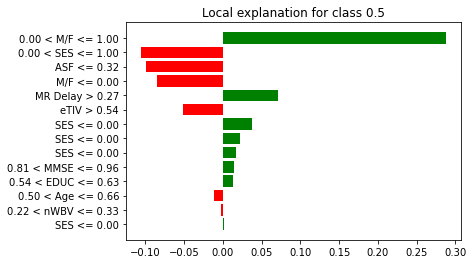

In [147]:
exp.as_pyplot_figure();

In [148]:
exp.as_list()

[('0.00 < M/F <= 1.00', 0.2874973380713915),
 ('0.00 < SES <= 1.00', -0.10530977434592648),
 ('ASF <= 0.32', -0.09914952205860048),
 ('M/F <= 0.00', -0.08465329384227951),
 ('MR Delay > 0.27', 0.07049309371179369),
 ('eTIV > 0.54', -0.05197769739409913),
 ('SES <= 0.00', 0.03757094102588883),
 ('SES <= 0.00', 0.022188605340018715),
 ('SES <= 0.00', 0.017425834104687433),
 ('0.81 < MMSE <= 0.96', 0.014514588265892065),
 ('0.54 < EDUC <= 0.63', 0.01264036898241755),
 ('0.50 < Age <= 0.66', -0.011565209499081198),
 ('0.22 < nWBV <= 0.33', -0.0027416178680857825),
 ('SES <= 0.00', 0.0019020506276954475)]

#### Variable Importance

let's put together the OHE's in the encodign order.

In [149]:
zval = zip(['M/F']*2+['SES']*5+['MR Delay','Age', 'EDUC', 'MMSE', 'eTIV', 'nWBV', 'ASF'],feature_importances)

In [238]:
# zval

In [151]:
var_imp_dict = {}
for i,j in zval: 
  if var_imp_dict.get(i):
    var_imp_dict[i]+=j
  else:
    var_imp_dict[i]=j

In [152]:
var_imp_dict

{'M/F': 0.305555522441864,
 'SES': 0.1444444179534912,
 'MR Delay': -0.03888890743255615,
 'Age': -0.06666669845581055,
 'EDUC': 0.02222222089767456,
 'MMSE': 0.14444441795349122,
 'eTIV': -0.016666674613952638,
 'nWBV': 0.04444442987442017,
 'ASF': 0.016666674613952638}

In [207]:
plot_imp = pd.DataFrame(var_imp_dict.values(), var_imp_dict.keys()).reset_index()
plot_imp.rename({'index':'feature_name', 0:'importance'}, axis=1, inplace=True)


In [208]:
plot_imp

,feature_name,importance
0,M/F,0.305556
1,SES,0.144444
2,MR Delay,-0.038889
3,Age,-0.066667
4,EDUC,0.022222
5,MMSE,0.144444
6,eTIV,-0.016667
7,nWBV,0.044444
8,ASF,0.016667


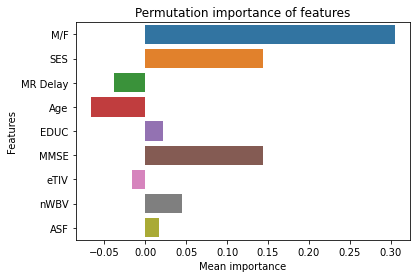

In [212]:

a = sns.barplot(data=plot_imp, y='feature_name', x='importance',  orient = 'h')
a.set(xlabel='Mean importance', ylabel='Features', title='Permutation importance of features');
# plt.legend(None)